In [22]:
from datasets import load_dataset
raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id")
raw_datasets

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [23]:
model_mbart = 'facebook/mbart-large-50-one-to-many-mmt'

from transformers import MBart50TokenizerFast
tokenizer = MBart50TokenizerFast.from_pretrained(model_mbart, src_lang="en_XX", tgt_lang="id_ID")

In [24]:
def normalize_text(text):
    text = text.lower()  # Lowercase
    # text = re.sub(r"[^\w\s]", "", text)  # Remove non-alphanumeric characters (except whitespace)
    # text = re.sub(r"\s+", " ", text)  # Replace excess whitespace with single space
    return text

source_lang = "en"
target_lang = "id"
def preprocess(data):
  inputs = [normalize_text(dt[source_lang]) for dt in data["translation"]]
  targets = [normalize_text(dt[target_lang]) for dt in data["translation"]]
  model_inputs = tokenizer(inputs, truncation=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, truncation=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tokenized_datasets = raw_datasets.map(preprocess, batched=True)

In [97]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(32))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(200))

In [98]:
from transformers import MBartForConditionalGeneration, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, Seq2SeqTrainer, EarlyStoppingCallback
model = MBartForConditionalGeneration.from_pretrained(model_mbart)
model = model.cuda()

In [99]:
# Freeze all layers except the decoder's last layers (adjust as needed)
count = 0
for param in model.get_encoder().parameters():
    param.requires_grad = False
    count+=1

print(f"freezes {count} layers")

freezes 198 layers


In [100]:
args = Seq2SeqTrainingArguments(
   f"mbart-large-50-one-to-many-mmt-finetuned-en-to-id",
   evaluation_strategy = "epoch",
   save_strategy= "epoch",
   learning_rate=1e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   weight_decay=0.01,
   save_total_limit=1,
   num_train_epochs=1,
   predict_with_generate=True,
   load_best_model_at_end= True,
   gradient_accumulation_steps=2,
)

In [101]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [102]:
import numpy as np
import evaluate
metric = evaluate.load('sacrebleu')
meteor = evaluate.load('meteor')
rouge = evaluate.load('rouge')

def postprocess_text(preds, labels):
   preds = [pred.strip() for pred in preds]
   labels = [[label.strip()] for label in labels]
   return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels!= -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # compute BLEU score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    # compute METEOR score
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    # Compute rouge
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    # inser all score into result
    prediction_lens = [np.count_nonzero(pred!= tokenizer.pad_token_id) for pred in preds]
    result = {'bleu' : result['score']}
    result["gen_len"] = np.mean(prediction_lens)
    result["meteor"] = meteor_result["meteor"]
    print(rouge_result)
    result["rouge1"] = rouge_result["rouge1"]
    result["rouge2"] = rouge_result["rouge2"]
    result["rougeL"] = rouge_result["rougeL"]
    result["rougeLsum"] = rouge_result["rougeLsum"]

    result = {k: round(v, 4) for k, v in result.items()}
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [103]:
trainer = Seq2SeqTrainer(
   model,
   args,
   train_dataset=small_train_dataset,
   eval_dataset=small_eval_dataset,
   data_collator=data_collator,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
   # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'rouge1': 0.01631032573829184, 'rouge2': 0.007294117647058824, 'rougeL': 0.016367485151383455, 'rougeLsum': 0.016541591647523855}
{'eval_loss': 3.3179049491882324, 'eval_bleu': 0.7137, 'eval_gen_len': 14.62, 'eval_meteor': 0.047, 'eval_rouge1': 0.0163, 'eval_rouge2': 0.0073, 'eval_rougeL': 0.0164, 'eval_rougeLsum': 0.0165, 'eval_runtime': 571.8047, 'eval_samples_per_second': 0.35, 'eval_steps_per_second': 0.023, 'epoch': 1.0}


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 590.174, 'train_samples_per_second': 0.054, 'train_steps_per_second': 0.002, 'train_loss': 3.234745979309082, 'epoch': 1.0}


TrainOutput(global_step=1, training_loss=3.234745979309082, metrics={'train_runtime': 590.174, 'train_samples_per_second': 0.054, 'train_steps_per_second': 0.002, 'total_flos': 1726931533824.0, 'train_loss': 3.234745979309082, 'epoch': 1.0})

In [104]:
# trainer.save_model('model/mbart-large-50-one-to-many-mmt-finetuned-en-to-id')

In [105]:
import pandas as pd
log_history = pd.DataFrame(trainer.state.log_history)
bleu_log = log_history["eval_bleu"].dropna().to_list()
meteor_log = log_history["eval_meteor"].dropna().to_list()
eval_log = log_history["eval_loss"].dropna().to_list()
rouge1_log = log_history["eval_rouge1"].dropna().to_list()
rouge2_log = log_history["eval_rouge2"].dropna().to_list()
rougeL_log = log_history["eval_rougeL"].dropna().to_list()
rougeLsum_log = log_history["eval_rougeLsum"].dropna().to_list()

In [106]:
log_history

,eval_loss,eval_bleu,eval_gen_len,eval_meteor,eval_rouge1,eval_rouge2,eval_rougeL,eval_rougeLsum,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.317905,0.7137,14.62,0.047,0.0163,0.0073,0.0164,0.0165,571.8047,0.35,0.023,1.0,1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,590.174,0.054,0.002,1.726932e+12,3.234746


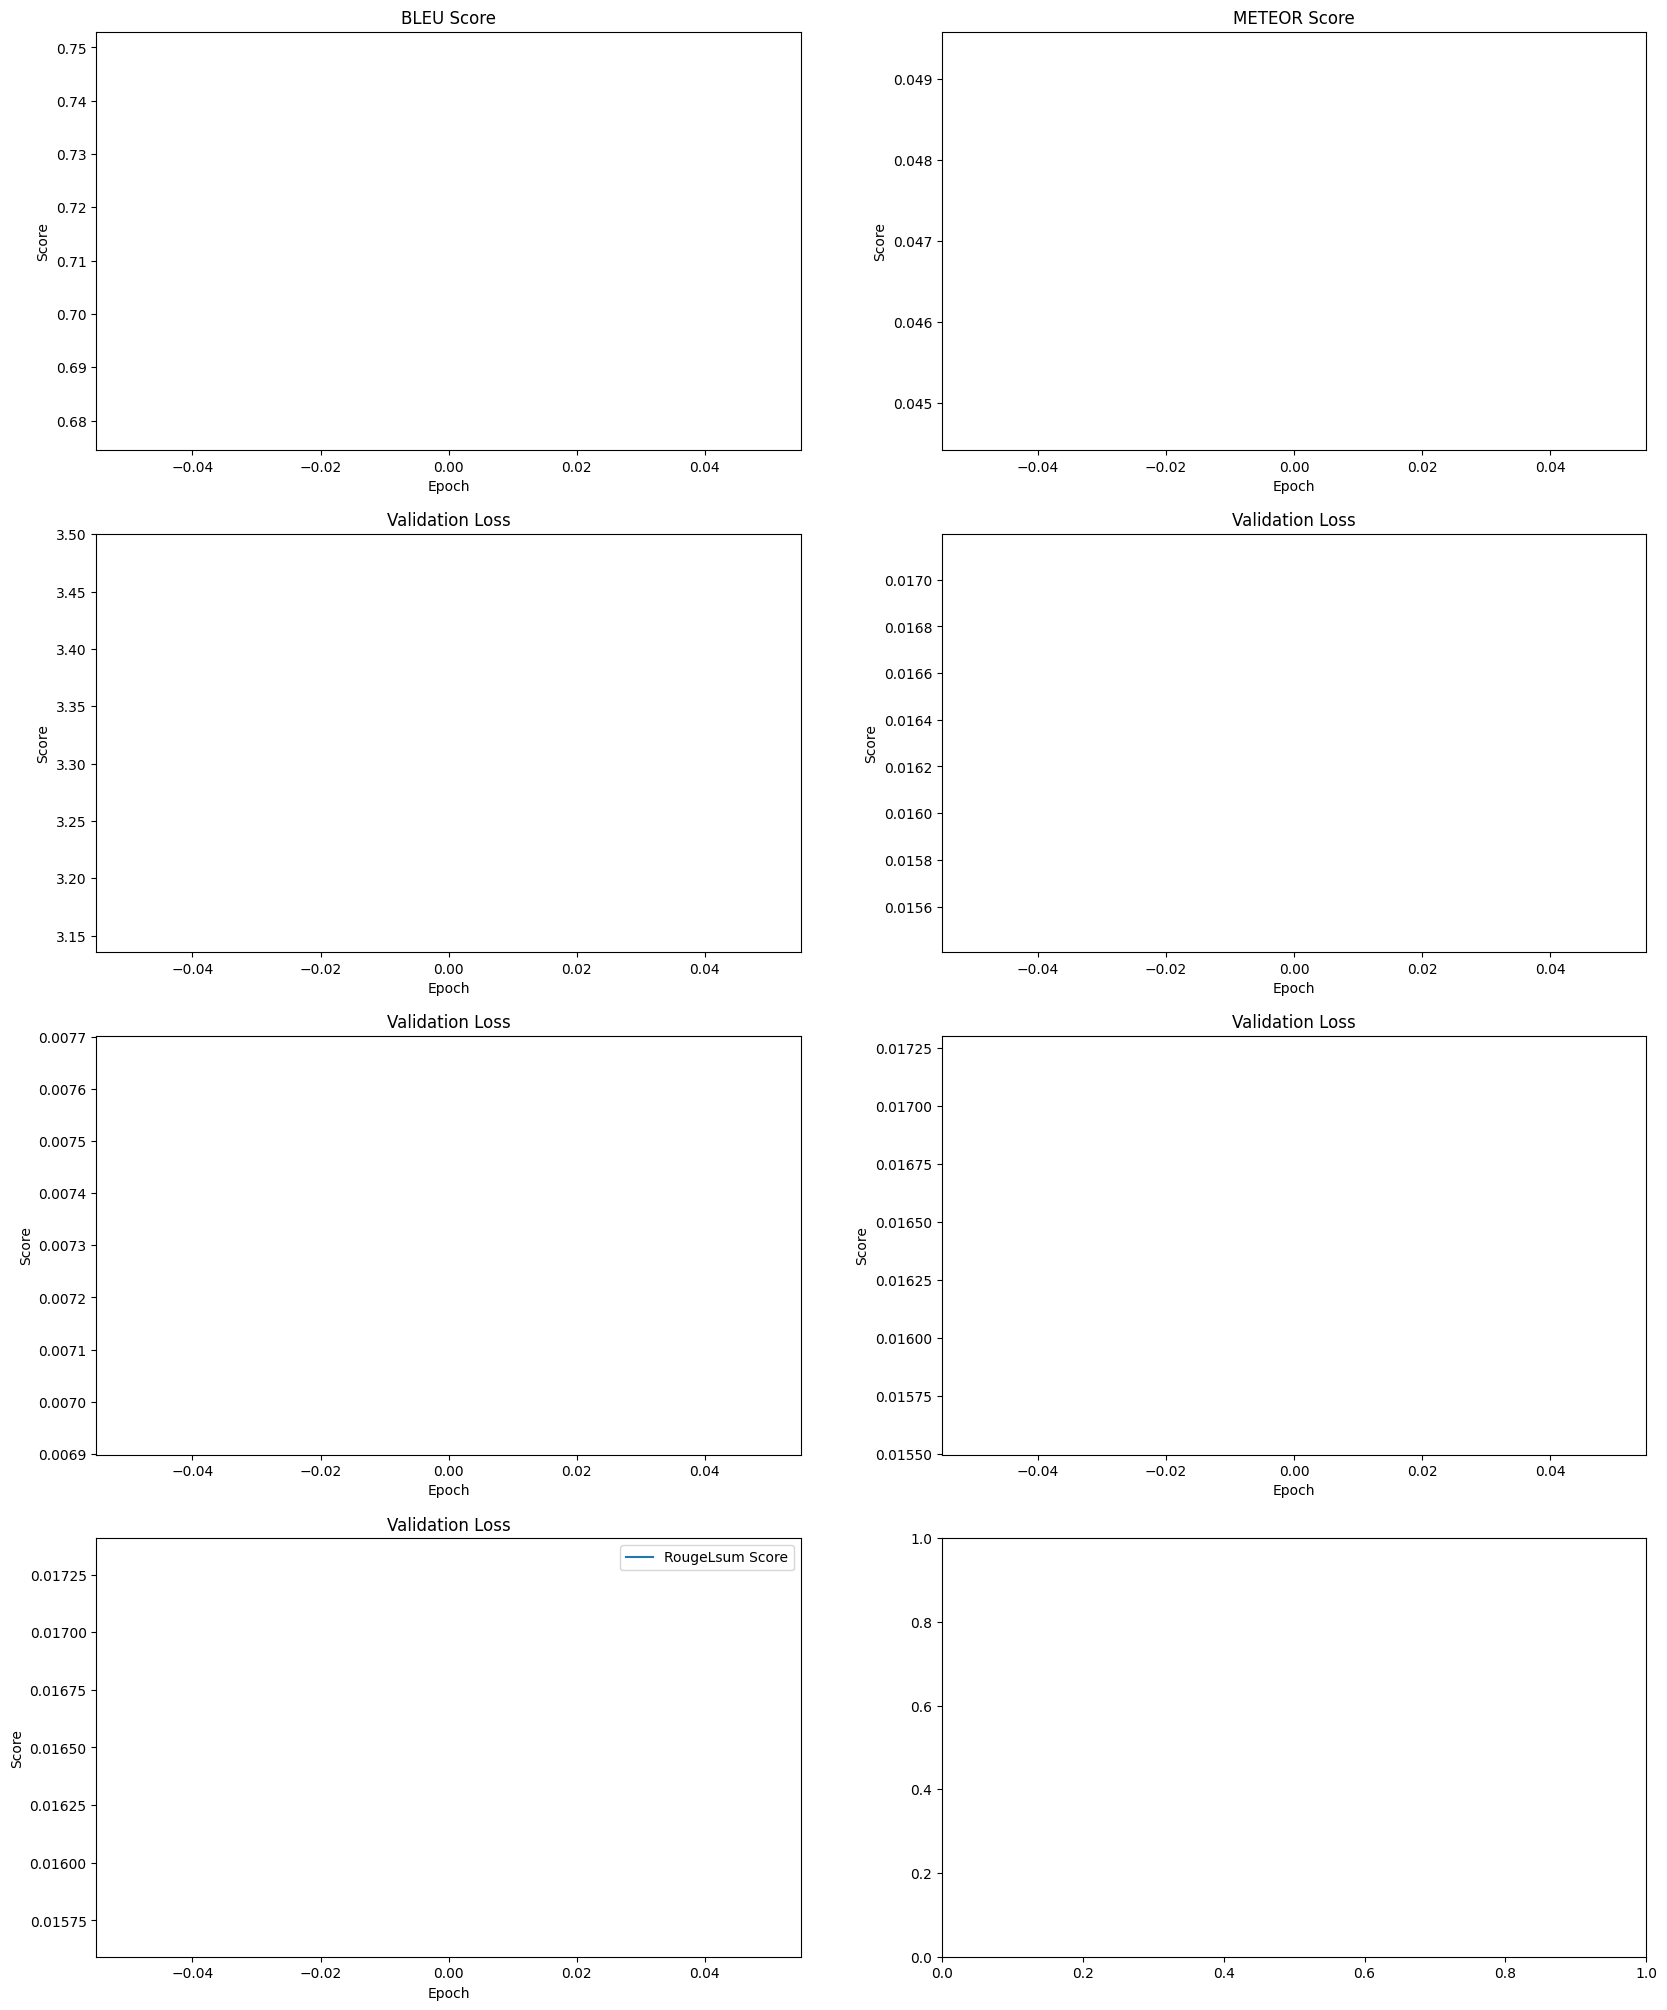

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 2, figsize=(20,25))
plt.subplot(4, 2, 1)
plt.plot(range(len(bleu_log)), bleu_log, label='BLEU Score')
plt.title("BLEU Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 2)
plt.plot(range(len(meteor_log)), meteor_log, label='METEOR Score')
plt.title("METEOR Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 3)
plt.plot(range(len(eval_log)), eval_log, label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 4)
plt.plot(range(len(rouge1_log)), rouge1_log, label='Rouge1 Score')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 5)
plt.plot(range(len(rouge2_log)), rouge2_log, label='Rouge2 Score')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 6)
plt.plot(range(len(rougeL_log)), rougeL_log, label='RougeL Score')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 7)
plt.plot(range(len(rougeLsum_log)), rougeLsum_log, label='RougeLsum Score')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.legend()
plt.show()

In [108]:
import csv
rows = []
for i in range(len(bleu_log)):
    row = {
        'Epoch': i+1,
        'BLEU': bleu_log[i],
        'METEOR': meteor_log[i],
        'validation_loss': eval_log[i],
    }
    rows.append(row)

# Define the fieldnames for the CSV file
fieldnames = ['Epoch', 'BLEU', 'METEOR', 'validation_loss']

# Write the rows to a CSV file
with open('mBART_1.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)